# 1-Librairies

In [ ]:
# Dataset
import kagglehub

# Standard libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm as notebook_tqdm
from PIL import Image
import glob

# tensorflow libraries
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

# keras libraries
from keras.optimizers import Adam

# scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Suppression des warnings
import warnings
warnings.filterwarnings("ignore")

# 2-Dataset

In [16]:
# Téléchargement du dataset depuis Kaggle
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Chemin d'accés du dossier du Dataset:", path)

# Classification des images de tumeurs cérébrales
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
# Affichage des noms de classes
print("Class names:", class_names)

# Convertir les noms de classes en binaire
# Ici, nous considérons 'notumor' comme 'Sain' et les autres comme 'Tumeur'
binary_class_names = ['Sain' if name == 'notumor' else 'Tumeur' for name in class_names]

# Affichage des noms de classes binaires
binary_class_names = dict(zip(class_names, binary_class_names))
print("Binary class names:", binary_class_names)

Chemin d'accés du dossier du Dataset: C:\Users\mgraz\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Binary class names: {'glioma': 'Tumeur', 'meningioma': 'Tumeur', 'notumor': 'Sain', 'pituitary': 'Tumeur'}


## 2.1-Dataset Entrainement

In [17]:
# Création de train_df à partir du dossier Training
train_images = []
train_binary_class_names = []

# Parcours des images dans le dossier Training
train_dir = os.path.join(path, 'Training')
for category in binary_class_names:
	category_path = os.path.join(train_dir, category)
	for img_name in os.listdir(category_path):
		train_images.append(os.path.join(category_path, img_name))
		train_binary_class_names.append(binary_class_names[category])
# Affichage du nombre d'images dans le dataset d'entraînement
print("Nombre d'images dans le dataset d'entraînement:", len(train_images))
# Création du DataFrame train_df
train_df = pd.DataFrame({"image_path": train_images, "label": train_binary_class_names})

X_train = train_df["image_path"].values
y_train = train_df["label"].values

Nombre d'images dans le dataset d'entraînement: 5712


## 2.2-Dataset Test

In [18]:
# Création de test_df à partir du dossier Testing
test_images = []
test_binary_class_names = []

# Parcours des images dans le dossier Testing
test_dir = os.path.join(path, 'Testing')
for category in class_names:
	category_path = os.path.join(test_dir, category)
	for img_name in os.listdir(category_path):
		test_images.append(os.path.join(category_path, img_name))
		test_binary_class_names.append(binary_class_names[category])

# Affichage du nombre d'images dans le dataset d'entraînement
print("Nombre d'images dans le dataset d'entraînement:", len(test_images))
# Création du DataFrame train_df
test_df = pd.DataFrame({"image_path": test_images, "label": test_binary_class_names})

X_test = test_df["image_path"].values
y_test = test_df["label"].values

Nombre d'images dans le dataset d'entraînement: 1311


## 2.3-Dataset de Validation

In [19]:
# Creation d'un dataset de validation
X_train, X_val, y_train, y_val = train_test_split(
    train_df["image_path"].to_numpy(),
    train_df["label"].to_numpy(),
    train_size=0.7,  # 80% des données pour l'entraînement
    test_size=0.3,   # 20% des données pour la validation
    random_state=42,
    stratify=train_df["label"],
)
val_df = pd.DataFrame({'image_path': X_val, 'label': y_val})

# Affichage du nombre d'images par classes dans le dataset de validation
print("Nombre d'images par classes dans le dataset de validation:", val_df['label'].value_counts())

Nombre d'images par classes dans le dataset de validation: label
Tumeur    1235
Sain       479
Name: count, dtype: int64


# 3-Preprocessing

## 3.1-Paramêtres

In [20]:
# Creation des hyperparamètres
def create_params():
    return {
        'batch_size': 32,  # Taille du batch
        'image_size': (224, 224),  # Taille des images pour VGG19
        'input_shape': (224, 224, 3),  # Forme d'entrée pour les images RGB
        'epochs': 20,  # Nombre d'époques pour l'entraînement
        'learning_rate': 0.001,  # Taux d'apprentissage pour l'optimiseur
    }

params = create_params()

## 3.2-ImageDataGenerator

In [21]:
# Création d'un ImageDataGenerator pour l'augmentation des données d'entraînement 
def create_datagen():
    """
    Crée un ImageDataGenerator pour l'augmentation des données d'entraînement.
    """
    return tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,         # Retourner les images horizontalement
        rotation_range=10,            # Rotation aléatoire des images
        zoom_range=0.1,               # Zoom aléatoire des images
        width_shift_range=0.1,        # Décalage horizontal aléatoire
        height_shift_range=0.1,       # Décalage vertical aléatoire
        brightness_range=(0.8, 1.2)   # Changement de la luminosité des images
    )
datagen = create_datagen()

## 3.3- Equilibrage du dataset d'entrainement

In [22]:
# Affichage du nombre d'images dans le DataFrame train_df
print("Nombre d'images dans le train_df:", len(train_df))
# Affichage du nombre d'images par classes dans le dataset d'entraînement
print("Nombre d'images par classes dans le dataset de train:", train_df['label'].value_counts())

Nombre d'images dans le train_df: 5712
Nombre d'images par classes dans le dataset de train: label
Tumeur    4117
Sain      1595
Name: count, dtype: int64


### 3.3.1-Séparation du label en 2 sous-classes

In [23]:
# Filtrage des images 'Sain' dans le DataFrame train_df
notumor_train_df = train_df[train_df['label'] == 'Sain']
# Filtrage des images 'Tumeur' dans le DataFrame train_df
# Ici, nous considérons 'Tumeur' comme toutes les autres classes sauf 'Sain
tumor_train_df = train_df[train_df['label'] == 'Tumeur']

# Affichage du nombre d'images dans le DataFrame filtré
print("Nombre d'images 'Sain':", len(notumor_train_df))
print("Nombre d'images 'Tumeur':", len(tumor_train_df))

Nombre d'images 'Sain': 1595
Nombre d'images 'Tumeur': 4117


### 3.3.2-Augmentation de la classe minoritaire

Nombre d'images 'Sain' dans le train_df: 1595
Nombre d'images augmentées 'Sain': 4785
Nombre d'images dans le DataFrame d'entrainement après augmentation: 8902


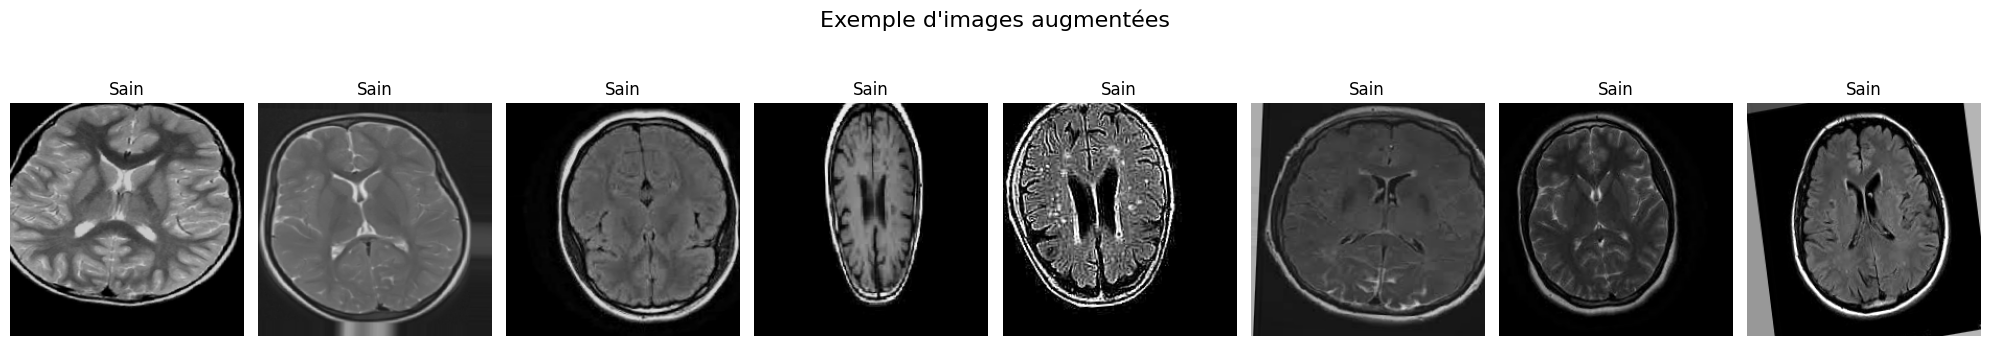

In [24]:
# Appliquer l'augmentation des données uniquement sur les images 'Sain'
notumor_train_df_datagen_images = []
# 
for x in notumor_train_df['image_path'].values:
    # Charger l'image, la redimensionner et la convertir en array
    img = tf.keras.utils.load_img(x, target_size=params['image_size'])
    img_array = tf.keras.utils.img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # nécessaire pour ImageDataGenerator
    for i, batch in enumerate(datagen.flow(img_array, batch_size=1)):
        notumor_train_df_datagen_images.append(batch[0])
        if i >= 2:  # 1 augmentations par image
            break
X_class1_aug = np.array(notumor_train_df_datagen_images)

# Affichage du nombre d'images augmentées et du DataFrame d'entrainement
print("Nombre d'images 'Sain' dans le train_df:", len(notumor_train_df))
print("Nombre d'images augmentées 'Sain':", len(X_class1_aug))
print("Nombre d'images dans le DataFrame d'entrainement après augmentation:", len(tumor_train_df) + len(X_class1_aug))

# Visualisation d'un échantillon d'images notumor (tirage aléatoire de 8 images du tableau numpy)
num_samples = 8
random_indices = np.random.choice(len(X_class1_aug), size=num_samples, replace=False)
sample_images = X_class1_aug[random_indices]

fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
for j, img_array in enumerate(sample_images):
    img = img_array.astype(np.uint8)
    axes[j].imshow(img)
    axes[j].axis("off")
    axes[j].set_title("Sain", fontsize=12)
plt.suptitle("Exemple d'images augmentées", fontsize=16)
plt.tight_layout()
plt.show()


### 3.3.3-Création du dataset d'entrainement augmenté

In [65]:
# Création du DataFrame d'entrainement avec les images augmentées
augmented_notumor_paths = notumor_train_df_datagen_images
augmented_notumor_labels = ['Sain'] * len(augmented_notumor_paths)

# On garde les images "Tumeur" telles quelles
tumor_paths = list(tumor_train_df['image_path'].values)
tumor_labels = ['Tumeur'] * len(tumor_paths)

# On concatène les deux listes
train_augmented_images = tumor_paths + augmented_notumor_paths
train_aug_binary_class_names = tumor_labels + augmented_notumor_labels

# Affichage du nombre d'images dans le dataset d'entraînement
print("Nombre d'images dans le dataset d'entraînement augmenté:", len(train_augmented_images))

# Création du DataFrame train_df_augmented
train_df_augmented = pd.DataFrame({"image_path": train_augmented_images, "label": train_aug_binary_class_names})
X_train = train_df_augmented["image_path"].values
y_train = train_df_augmented["label"].values

# Sauvegarde du dataset augmenté
output_path = "./train_df_augmented"
notumor_path = os.path.join(output_path, "Sain")
tumor_path = os.path.join(output_path, "Tumeur")

os.makedirs(notumor_path, exist_ok=True)
os.makedirs(tumor_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

for i, img_array in enumerate(augmented_notumor_paths):
    img = Image.fromarray(img_array.astype(np.uint8))
    img.save(os.path.join(notumor_path, f"notumor{i}.png"))

for i, img_path in enumerate(tumor_paths):
    img = Image.open(img_path)
    img = img.resize(params['image_size'])
    img.save(os.path.join(tumor_path, f"tumor{i}.png"))

print("Nombre d'images par classes dans le dataset d'entraînement augmenté:", train_df_augmented['label'].value_counts())

Nombre d'images dans le dataset d'entraînement augmenté: 8902
Nombre d'images par classes dans le dataset d'entraînement augmenté: label
Sain      4785
Tumeur    4117
Name: count, dtype: int64


## 3.4-Création des dataset ImageDataGenerator

In [82]:
# Récupérer tous les chemins d'images et labels depuis le dossier train_df_augmented
sain_image_paths = sorted(glob.glob(os.path.join(output_path, "Sain", "*.png")))
tumeur_image_paths = sorted(glob.glob(os.path.join(output_path, "Tumeur", "*.png")))

train_augmented_filepaths = sain_image_paths + tumeur_image_paths
train_augmented_labels = ["Sain"] * len(sain_image_paths) + ["Tumeur"] * len(tumeur_image_paths)

train_augmented_df = pd.DataFrame({
    "image_path": train_augmented_filepaths,
    "label": train_augmented_labels
})

# Création du générateur pour les données d'entraînement augmenté
train_augmented_datagen = datagen.flow_from_dataframe(
    train_augmented_df,
    x_col='image_path',
    y_col='label',
    target_size=params['image_size'],
    batch_size=params['batch_size'],
    class_mode='binary'
)

# Création du générateur pour les données de validation
val_datagen = datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=params['image_size'],
    batch_size=params['batch_size'],
    class_mode='binary'
)

# Création du générateur pour les données de test
test_datagen = datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=params['image_size'],
    batch_size=params['batch_size'],
    class_mode='binary',
    shuffle=False
)

Found 8902 validated image filenames belonging to 2 classes.
Found 1714 validated image filenames belonging to 2 classes.
Found 1311 validated image filenames belonging to 2 classes.


# 4-CNN (Réseau Convolutif)

## 4.1-Création du modèle 

In [27]:
# Création du modèle CNN
def create_cnn_model(img_shape):
    model = Sequential([

        # Premier bloc convolutionnel
        Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Deuxième bloc convolutionnel
        Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Troisième bloc convolutionnel
        Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),

        # Classification
        Flatten(),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")  # 1 sortie pour la classification binaire
    ])

    return model

# Compilation CNN
def compile_models(cnn_model):
    compile_config = {
        'optimizer': Adam(learning_rate=params['learning_rate']),
        'loss': 'binary_crossentropy',  # Utilisation de 'binary_crossentropy' pour la classification binaire
        'metrics': ['accuracy', 'Precision', 'Recall']
    }

    # Compilation du modèle
    cnn_model.compile(**compile_config)

    return cnn_model


# Création du modèle CNN avec la bonne forme d'entrée
cnn_model = create_cnn_model(params['input_shape'])

# Compiler le modele CNN
cnn_model = compile_models(cnn_model)

# Affichage des architectures
print("\n=== ARCHITECTURE CNN ===")
cnn_model.summary()


=== ARCHITECTURE CNN ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,235,425 (12.34 MB)

 Trainable params: 3,235,201 (12.34 MB)

 Non-trainable params: 224 (896.00 B)

## 4.2-Entrainement du modele

In [28]:
# Création des callbacks
def create_callbacks():
    callbacks_list = [

        # Sauvegarde du meilleur modèle
        callbacks.ModelCheckpoint(
            './models/model_cnn_US1_v1.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),

        # Early stopping pour éviter l'overfitting
        callbacks.EarlyStopping(
            monitor='loss',
            patience=1,
            restore_best_weights=True,
        )
    ]
    return callbacks_list

# Création des callbacks
callbacks_list = create_callbacks()

# Entraînement du modèle
print("=== Début de l'entraînement ===")

history = cnn_model.fit(
    train_augmented_datagen,
    validation_data=val_datagen,
    epochs=params['epochs'],
    callbacks=callbacks_list,
    verbose=1,
)

print("=== Entraînement terminé ===")

=== Début de l'entraînement ===
Epoch 1/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - Precision: 0.8036 - Recall: 0.8296 - accuracy: 0.8293 - loss: 0.6345
Epoch 1: val_accuracy improved from -inf to 0.89965, saving model to ./models/model_cnn_US1_v1.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 255s 904ms/step - Precision: 0.8038 - Recall: 0.8297 - accuracy: 0.8294 - loss: 0.6336 - val_Precision: 0.9411 - val_Recall: 0.9182 - val_accuracy: 0.8996 - val_loss: 0.2404
Epoch 2/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - Precision: 0.9343 - Recall: 0.9131 - accuracy: 0.9286 - loss: 0.1960
Epoch 2: val_accuracy improved from 0.89965 to 0.95858, saving model to ./models/model_cnn_US1_v1.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 251s 901ms/step - Precision: 0.9344 - Recall: 0.9131 - accuracy: 0.9287 - loss: 0.1959 - val_Precision: 0.9634 - val_Recall: 0.9798 - val_accuracy: 0.9586 - val_loss: 0.1101
Epoch 3/20
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - Precision: 0.9625 - Recall: 0.9335 - accuracy: 0.95

In [29]:
history.history.keys()

dict_keys(['Precision', 'Recall', 'accuracy', 'loss', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss'])

## 4.3-Evaluation du modèle

In [30]:
# Evaluation du modèle
loss, accuracy, precision, recall = cnn_model.evaluate(test_datagen)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")
print(f"Test Precision: {precision:0.5f}")
print(f"Test Recall: {recall:0.5f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 354ms/step - Precision: 0.9907 - Recall: 0.9078 - accuracy: 0.9194 - loss: 0.2799
Test Loss: 0.22694
Test Accuracy: 0.93364
Test Precision: 0.98577
Test Recall: 0.91722


## 4.4-Visualisation du modèle

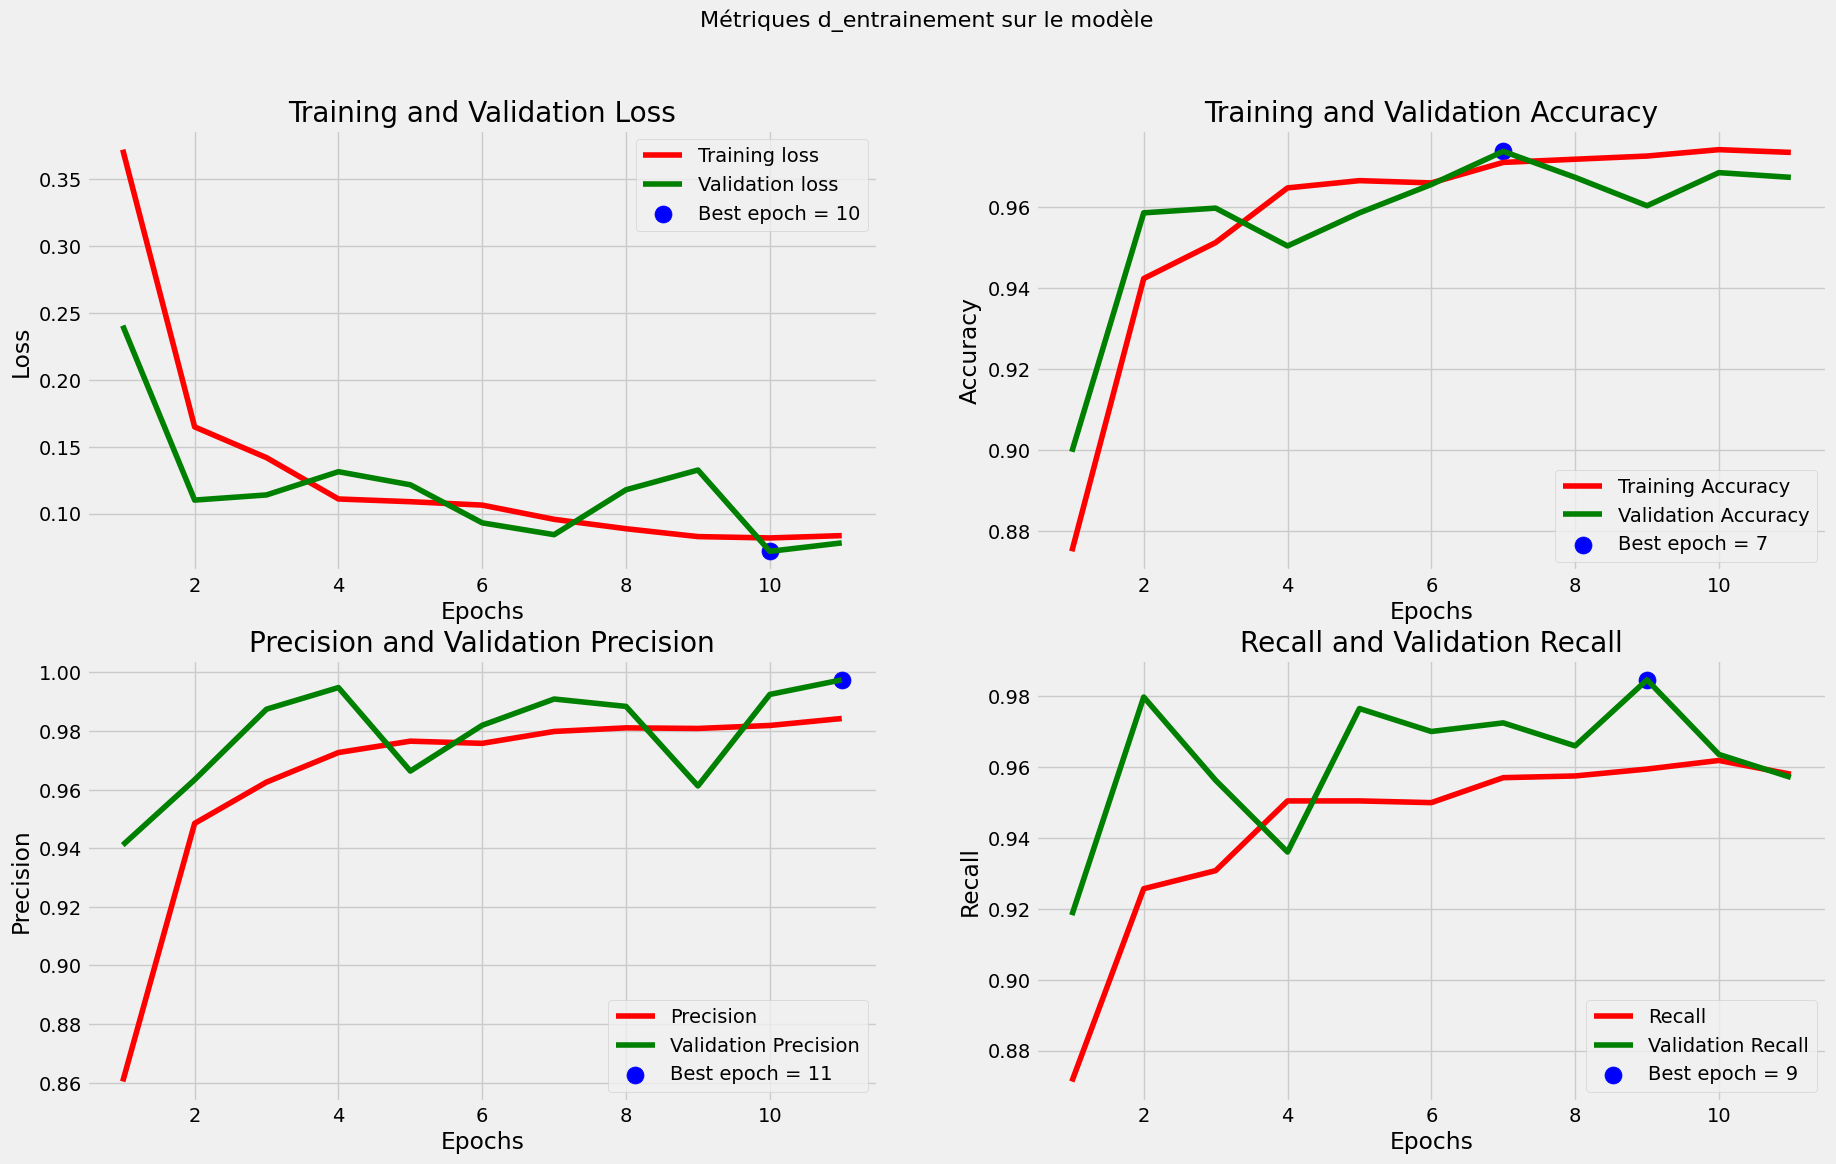

In [89]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['Precision']
tr_recall = history.history['Recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_Precision']
val_recall = history.history['val_Recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

# affichage des métriques Loss d'entraînement et de validation
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Affichage des métriques Accuracy d'entraînement et de validation
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Affichage des métriques de précision
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Affichage des métriques de rappel
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Métriques d_entrainement sur le modèle', fontsize=16)
plt.show()

In [87]:
def test_model(model, test_datagen):
    # Charger les poids du meilleur modèle sauvegardé
    model.load_weights('./models/model_cnn_US1_v1.keras')
    predictions = model.predict(test_datagen)
    # Pour une sortie sigmoid (binaire), arrondir à 0 ou 1
    if predictions.shape[1] == 1:
        predicted_classes = (predictions > 0.5).astype(int).flatten()
    else:
        predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_datagen.classes
    test_acc = 100 * np.sum(predicted_classes == true_classes) / len(true_classes)

    print(f"Test Accuracy: {test_acc:.2f}%\n")

    print("Classification Report:\n")
    print(classification_report(
        true_classes,
        predicted_classes,
        target_names=['Sain', 'Tumeur'],
        labels=[0, 1]
    ))

print("\nLoading best model for testing...")
try:
    cnn_model
except NameError:
    print("Erreur : 'cnn_model' n'est pas défini. Veuillez exécuter la cellule où le modèle est créé.")
else:
    test_model(cnn_model, test_datagen)


Loading best model for testing...
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 335ms/step
Test Accuracy: 93.14%

Classification Report:

              precision    recall  f1-score   support

        Sain       0.83      0.98      0.90       405
      Tumeur       0.99      0.91      0.95       906

    accuracy                           0.93      1311
   macro avg       0.91      0.94      0.92      1311
weighted avg       0.94      0.93      0.93      1311



# 5-Prédiction

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


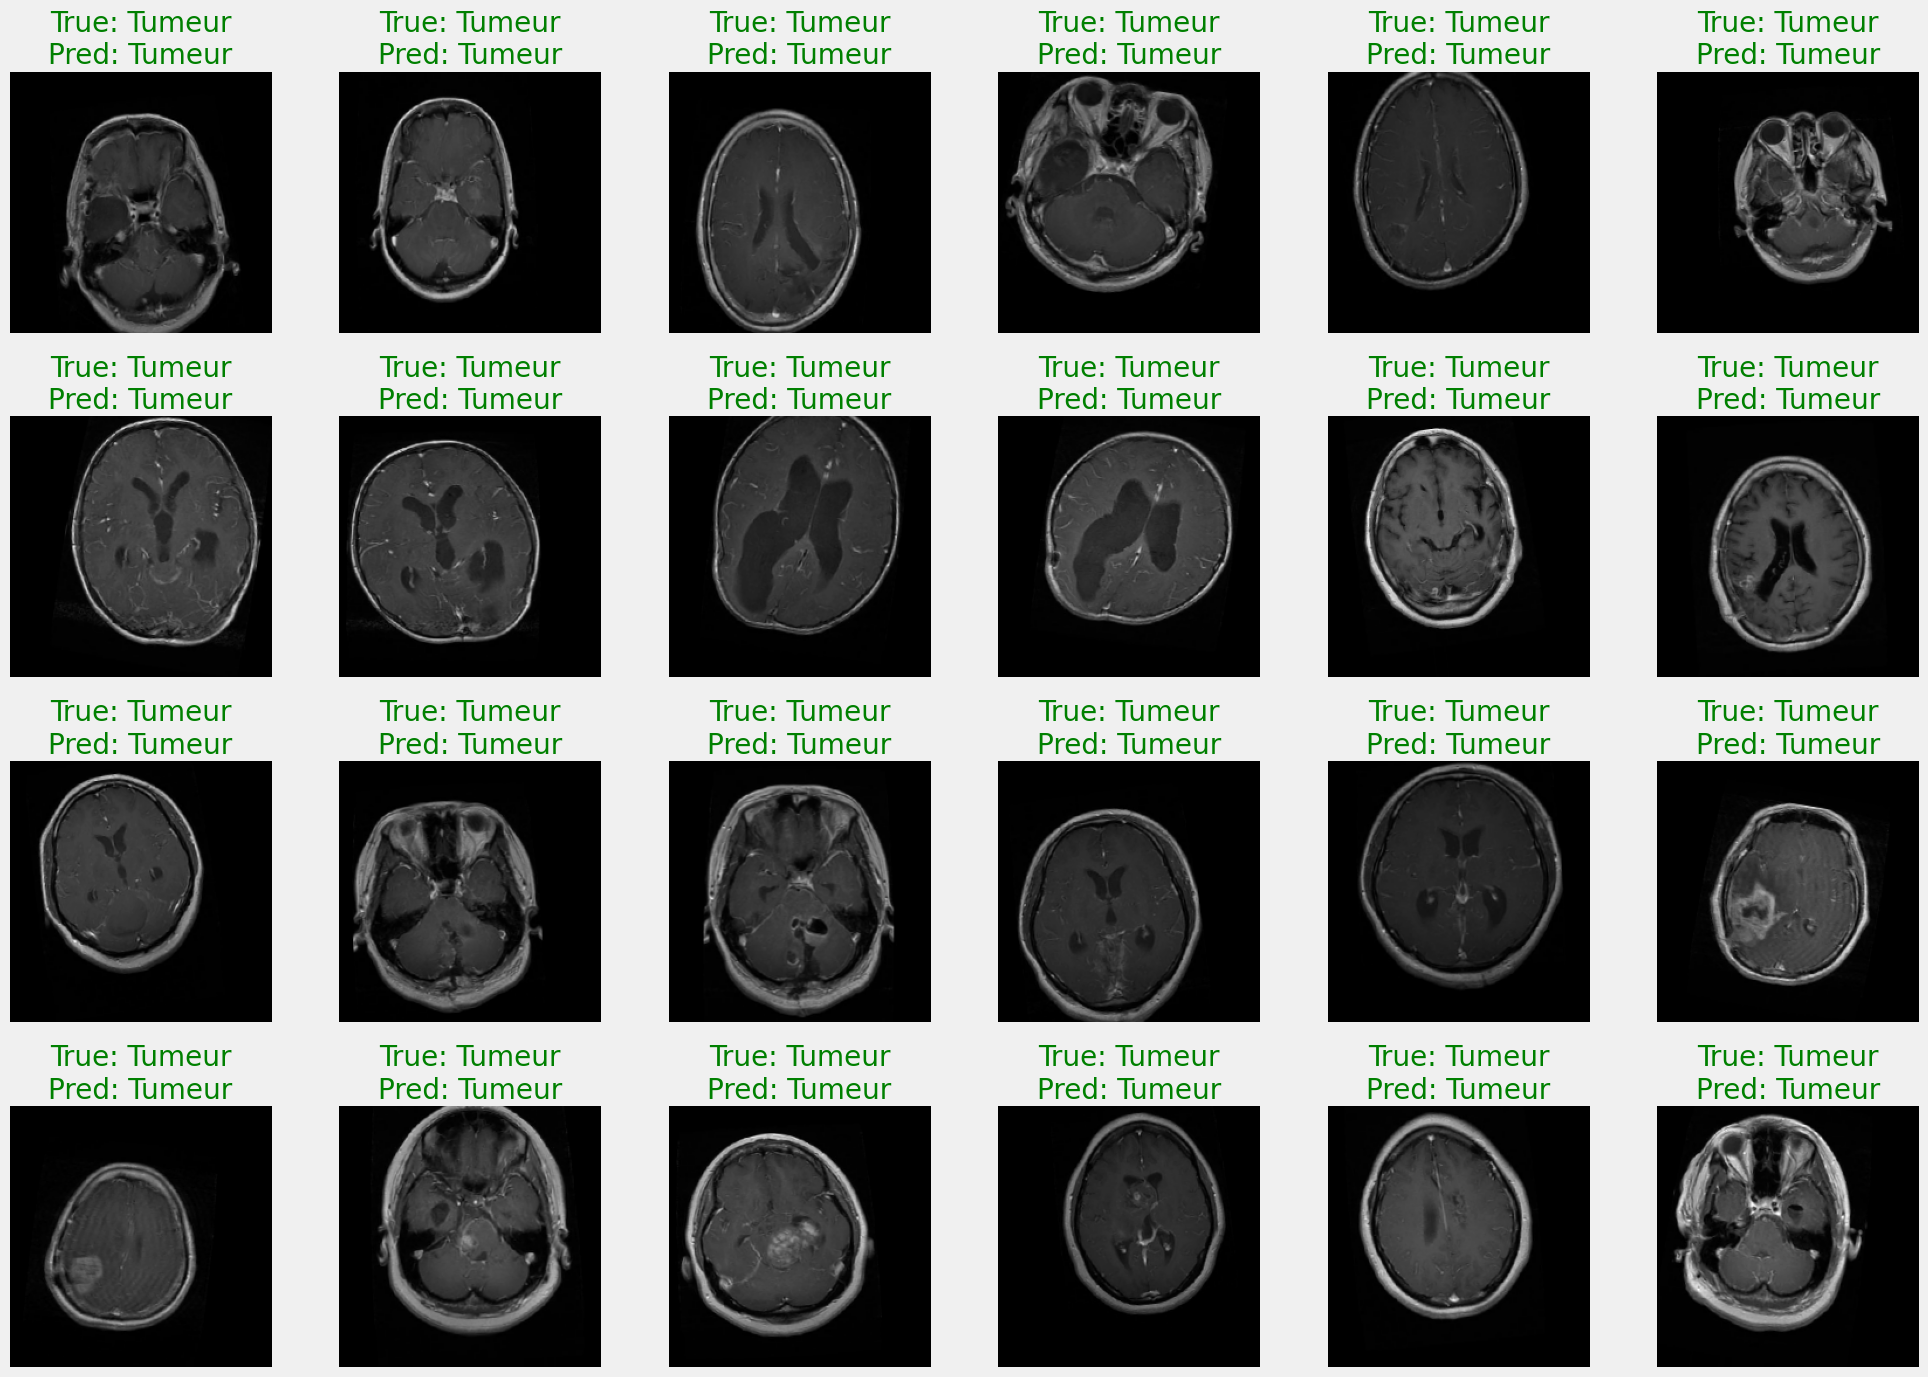

In [ ]:
# Visualisation des prédictions sur un échantillon d'images du dataset de test
def multi_to_binary(y_class_pred, positif_classes=['glioma', 'meningioma', 'pituitary']):
    return ['Tumeur' if y in positif_classes else 'Sain' for y in y_class_pred]

# Prédire les classes sur le jeu de test avec le générateur
y_pred_probs = cnn_model.predict(test_datagen)
# Pour une sortie sigmoid (binaire), arrondir à 0 ou 1
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
# Récupérer le mapping inverse des indices de classes
idx_to_class = {v: k for k, v in test_datagen.class_indices.items()}
# Convertir les indices en noms de classes
y_pred_class_names = [idx_to_class[int(i)] for i in y_pred_classes]
# Convertir les classes en "Tumeur"/"Sain"
y_binary_pred = multi_to_binary(y_pred_class_names)
# Convertir les classes en "Tumeur"/"Sain" pour les labels réels
y_true_class_names = [idx_to_class[int(i)] for i in test_datagen.classes]
y_binary_true = multi_to_binary(y_true_class_names)

# Definir la fonction predictions
def predictions(model, test_generator, num_samples=20, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    rows = int(np.floor(np.sqrt(num_samples)))
    cols = int(np.ceil(num_samples / rows))

    # Lot d'images et labels du test generator
    images, true_labels_encoded = next(test_generator)
    # Convertir les indices en noms de classes
    true_class_names = [class_names[np.argmax(label)] for label in true_labels_encoded]
    # Convertir en labels binaires
    true_labels = multi_to_binary(true_class_names, positif_classes=['glioma', 'meningioma', 'pituitary'])

    # Obtenir les predictions du modèle
    predictions_encoded = model.predict(images)
    pred_class_names = [class_names[np.argmax(pred)] for pred in predictions_encoded]
    predicted_labels = multi_to_binary(pred_class_names, positif_classes=['glioma', 'meningioma', 'pituitary'])

    batch_len = min(num_samples, len(images), len(true_labels), len(predicted_labels))
    for i in range(batch_len):
        plt.subplot(rows, cols, i + 1)
        # Redimmensionner image pour affichage
        image = images[i] / 255.0
        plt.imshow(image)
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]
        color = "green" if true_label == predicted_label else "red"
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

try:
    cnn_model
except NameError:
    print("Erreur : 'cnn_model' n'est pas défini. Veuillez exécuter la cellule où le modèle est créé.")
else:
    predictions(model=cnn_model,
                test_generator=test_datagen,
                num_samples=24,
                figsize=(20, ))